# Product Matching - Evaluation

Evaluate system performance with Recall@k and MRR metrics

In [1]:
import sys
sys.path.append('src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from embedding_engine import EmbeddingEngine
from retrieval import HybridRetriever

C:\Users\Ahmed\AppData\Roaming\Python\Python312\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## Load Models

In [2]:
df = pd.read_csv('data/product_catalogue_processed.csv')
print(f"Loaded {len(df)} products")

engine = EmbeddingEngine()
engine.load_index('models')

retriever = HybridRetriever(engine, df)

Loaded 5270 products
Loading embedding model: all-MiniLM-L6-v2...
Model loaded. Embedding dimension: 384
Building BM25 index...
BM25 index built with 5270 documents


## Create Test Queries

In [ ]:
test_cases = []

sample = df.sample(30)

for _, row in sample.iterrows():
    test_cases.append({
        'query': row['title'],
        'expected_id': row['product_id']
    })
    
    words = row['title'].split()
    if len(words) > 2:
        test_cases.append({
            'query': ' '.join(words[:2]),
            'expected_id': row['product_id']
        })

print(f"Created {len(test_cases)} test cases")

Created 58 test cases


## Run Evaluation

In [ ]:
results = []

for test in test_cases:
    query = test['query']
    expected_id = str(test['expected_id'])
    
    search_results = retriever.search_hybrid(query, k=5)
    returned_ids = [str(r['product_id']) for r in search_results]
    
    try:
        position = returned_ids.index(expected_id) + 1
    except:
        position = None
    
    results.append({
        'query': query,
        'found_at_1': 1 if position == 1 else 0,
        'found_at_5': 1 if position and position <= 5 else 0,
        'reciprocal_rank': 1/position if position else 0
    })

eval_df = pd.DataFrame(results)

## Calculate Metrics

In [5]:
recall_1 = eval_df['found_at_1'].mean() * 100
recall_5 = eval_df['found_at_5'].mean() * 100
mrr = eval_df['reciprocal_rank'].mean()

print("\n" + "="*50)
print("EVALUATION RESULTS")
print("="*50)
print(f"Recall@1:  {recall_1:.1f}%")
print(f"Recall@5:  {recall_5:.1f}%")
print(f"MRR:       {mrr:.3f}")
print("="*50)


EVALUATION RESULTS
Recall@1:  94.8%
Recall@5:  96.6%
MRR:       0.957


## Visualize Results

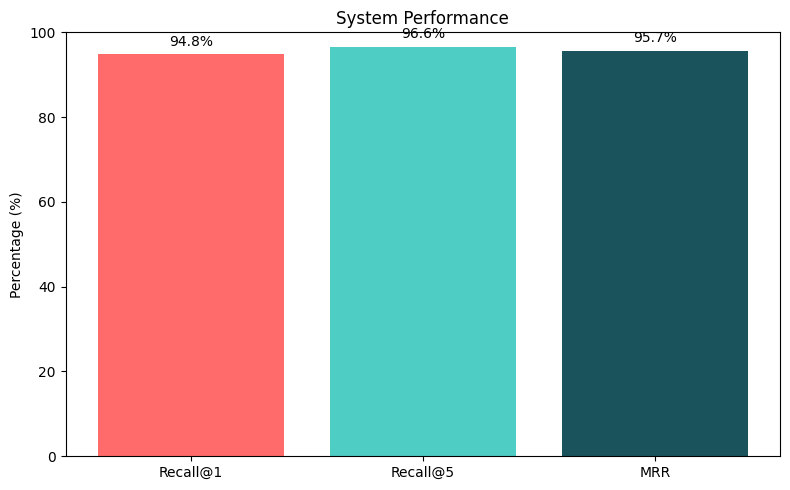


✓ Evaluation complete!


In [7]:
fig, ax = plt.subplots(figsize=(8, 5))

metrics = ['Recall@1', 'Recall@5', 'MRR']
values = [recall_1, recall_5, mrr * 100]

ax.bar(metrics, values, color=['#FF6B6B', '#4ECDC4', '#1A535C' ])
ax.set_ylabel('Percentage (%)')
ax.set_title('System Performance')
ax.set_ylim(0, 100)

for i, v in enumerate(values):
    ax.text(i, v + 2, f'{v:.1f}%', ha='center')

plt.tight_layout()
plt.show()

print("\n✓ Evaluation complete!")